In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
from numpy.polynomial.hermite import hermval
x = np.arange(-6, 6, 0.1)
h0 = hermval(x, [1, 0, 0])
h1 = hermval(x, [0, 1, 0])
h2 = hermval(x, [0, 0, 1])/10
#plt.plot(x, h0)
#plt.plot(x, h1)
#plt.plot(x, h2)

In [3]:
def gaussian(x, m=0., s=1.0):
    out = 1/(s*np.sqrt(2*np.pi))*np.exp(-(x-m)**2./(2.*s**2.))
    return out / out.sum() / (x[1] - x[0])

gh0 = gaussian(x) * h0
gh1 = gaussian(x) * h1
gh2 = gaussian(x) * h2
#plt.plot(x, gh0)
#plt.plot(x, gh1)
#plt.plot(x, gh2)

## Update: it looks like the actual code uses chebyshev1 polynomials!

Note these are essentially the same but with different scale factors.

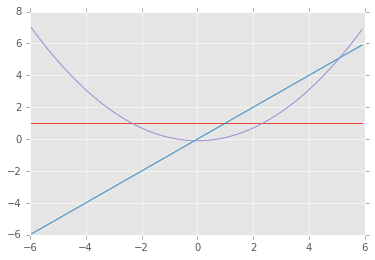

In [4]:
from numpy.polynomial.chebyshev import chebval
h0 = chebval(x, [1, 0, 0])
h1 = chebval(x, [0, 1, 0])
h2 = chebval(x, [0, 0, 1])/10
plt.plot(x, h0)
plt.plot(x, h1)
plt.plot(x, h2)

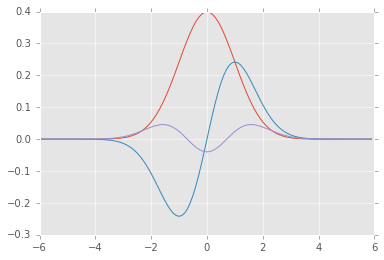

In [5]:
gh0 = gaussian(x) * h0
gh1 = gaussian(x) * h1
gh2 = gaussian(x) * h2
plt.plot(x, gh0)
plt.plot(x, gh1)
plt.plot(x, gh2)

## Generate AL basis funcs now...

use same parameters as from the stack.

In [6]:
# Parameters from stack
sigGauss = [0.75, 1.5, 3.0]
degGauss = [4, 2, 2]
betaGauss = 2   # in the Becker et al. paper sigGauss is 1 but PSF is more like 2 pixels?
spatialKernelOrder = 2  # polynomial for modifying the shape of the kernel across the image
spatialBackgroundOrder = 1  # polynomial for adding background gradient to fit
# Parameters from and Becker et al. (2012)
#sigGauss = [0.75, 1.5, 3.0]
#degGauss = [6, 4, 2]

def chebBasis(x, ord):
    coef = np.zeros(ord+1)
    coef[-1] = 1
    ch = chebval(x, coef)
    return ch, coef

def chebGauss(x, m=0., s=1., ord=0, beta=1.):
    ga = gaussian(x, m, s/beta)
    ch, coef = chebBasis(x, ord)
    print s, ord, coef
    return ga * ch

0.75 0 [ 1.]
0.75 1 [ 0.  1.]
0.75 2 [ 0.  0.  1.]
0.75 3 [ 0.  0.  0.  1.]
1.5 0 [ 1.]
1.5 1 [ 0.  1.]
3.0 0 [ 1.]
3.0 1 [ 0.  1.]


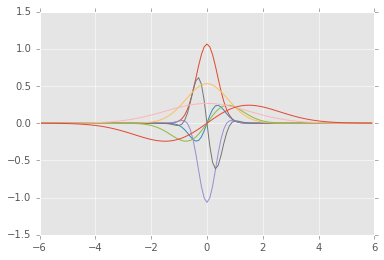

In [7]:
basis = [chebGauss(x, m=0, s=sig, ord=deg, beta=betaGauss) \
         for i,sig in enumerate(sigGauss) for deg in range(degGauss[i])] #, kernelOrd=ko) for ko in range(spatialKernelOrder+1)]
basis = np.vstack(basis).T  # put the bases into columns
# basis = pd.DataFrame(basis); basis.plot()
for b in basis.T:
    plt.plot(x, b)

Make the two "images". `im1` is the template, `im2` is the science image.

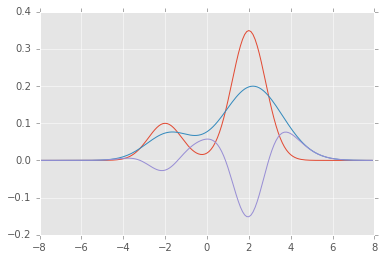

In [8]:
xim = np.arange(-8, 8, 0.1)  # assume image coords are centered on sources
im1 = 0.2 * gaussian(xim, m=-2.0, s=0.8) + 0.7 * gaussian(xim, m=2.0, s=0.8)  # template
im2 = 0.2 * gaussian(xim, m=-1.8, s=1.1) + 0.7 * gaussian(xim, m=2.2, s=1.4)  # science image; include a slight registration error and psf sigma variation
plt.plot(xim, im1); plt.plot(xim, im2); plt.plot(xim, im2-im1)

Convolve im2 with the basis functions, and make these the *new* bases.

(160, 8)
(160, 16)
(160, 2)
(160, 26)


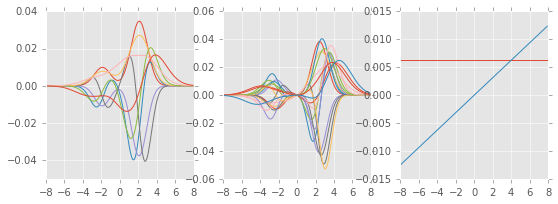

In [9]:
fig = plt.figure(figsize=(9, 3))

# Single call to do it with all bases
# First make the original (non spatially modified) basis
basis2 = [np.convolve(im1, b, mode='same') - im1 for b in basis.T]
basis2 = np.vstack(basis2).T
plt.subplot(1, 3, 1)
for b in (basis2 / np.abs(basis2).sum(0)).T:
    plt.plot(xim, b)
print basis2.shape

# Then make the spatially modified basis by simply multiplying the constant
#  basis (basis2 from above) by a polynomial along the image coordinate.
# Note that since we are *not* including i=0, this *does not include* basis2.
if spatialKernelOrder > 0:
    xx = xim/np.max(np.abs(xim))
    basis2m = [b * xx**i for i in range(1, spatialKernelOrder+1) for b in basis2.T]
    basis2m = np.vstack(basis2m).T
    plt.subplot(1, 3, 2)
    for b in (basis2m / np.abs(basis2m).sum(0)).T:
        plt.plot(xim, b)
    print basis2m.shape
    basis2 = np.hstack([basis2, basis2m])

# Then make the spatial background part
if spatialBackgroundOrder >= 0:
    bgBasis = [chebBasis(xim, ord)[0] for ord in range(spatialBackgroundOrder+1)]
    bgBasis = np.vstack(bgBasis).T
    plt.subplot(1, 3, 3)
    for b in (bgBasis / np.abs(bgBasis).sum(0)).T:
        plt.plot(xim, b)
    basis2 = np.hstack([basis2, bgBasis])
    print bgBasis.shape

#basis2 /= np.abs(basis2.sum(0))
print basis2.shape
plt.show()

Do the linear fit to compute the matching kernel. The resulting fit is the convolved diffim.

Here we are plotting the resulting fitted diffim (red) vs. the actual diffim (blue)

[  1.40374249e-11]
[ -2.84514427e+00   4.99223319e+00  -6.72635618e+00   5.01584789e+00
  -3.41923070e-01  -2.29138646e-02   9.11712502e-02  -4.32567824e-02
  -2.09704206e+01   4.93456749e+01  -2.87835841e+01   2.56127618e+00
  -3.76202160e-01  -6.05966324e-01   2.01888744e-01   8.28381346e-02
  -3.79910348e+01   4.31517847e+01  -5.46811430e+00   1.03783219e+00
   2.26364135e+00   3.56373474e-01  -4.79911171e-01   2.41440803e-03
   1.50978872e-05   9.12563707e-07]
(160, 26) (160,) (26,)


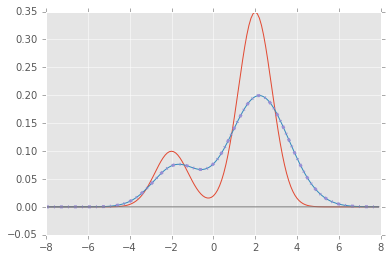

In [22]:
pars, resid, _, _ = np.linalg.lstsq(basis2, im2)
print resid; print pars
fit = (pars * basis2).sum(1)
print basis2.shape, fit.shape, pars.shape
#plt.plot(x, im2 - fit)  # science - convolved template (red)
#plt.plot(x, im2 - im1)  # science - original template (blue)
plt.plot(xim, im1)  # original template (red)
plt.plot(xim, fit)  # convolved template (blue)  -- note looks purple because it's right on top of im2
plt.plot(xim, im2, ls='-.', lw=3)  # science image (dotted, purple)
plt.plot(xim, im2 - fit)  # diffim (grey)

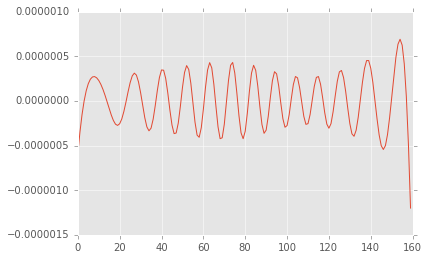

In [23]:
plt.plot(im2 - fit)  # diffim (grey)

Look at the resulting matching kernel by multiplying the fitted parameters times the original basis funcs. and test that actually convolving it with the template gives us a good subtraction.

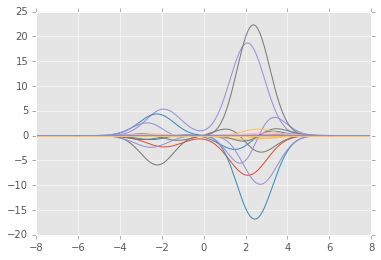

In [11]:
# First let's plot the bases times their coefficients
fit = pars * basis2
for f in fit.T:
    plt.plot(xim, f)

OK, this is probably overfitting - hence the need for either parameter selection (via BIC?) or PCA.